In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [2]:
work_direc = ''
os.chdir(work_direc)

Trained_models_direc = os.path.join(work_direc, 'Trained_models')

In [3]:
from data_processing_nd_encoding_related_functions import prepare_IO_dataset, preprocess_dataset

### Data and parameters loading

## Explanation: Data Preprocessing and Model Input Preparation

This section of the code is responsible for preparing the dataset for modeling purposes by using two key functions from the custom module `data_processing_nd_encoding_related_functions`:

1. **`preprocess_dataset`**: Handles the preprocessing of raw data, including filtering, cleaning, encoding, and handling outliers.
2. **`prepare_IO_dataset`**: Converts the processed dataset into a format suitable for machine learning models by applying one-hot encoding and preparing input-output features.

### Key Steps in the Code:

1. **Specify Dataset and Target Variables**:
   - **`data_file`**: Specifies the input dataset (`Theatre_data.csv`).
   - **`target_data_types`**: Defines the target variable(s) for prediction as in data_file (e.g., `'H4 Minutes'`).

2. **Define Input Features**:
   - **Essential Features (`model_input_features_ess`)**: These are mandatory input features, such as `'Actual Procedure 1 Code 1'`.
   - **Additional Features (`model_input_features_addi`)**: Includes contextual or auxiliary features like hospital data, patient demographics, and procedure-related information.

3. **Apply Data Filtering and Categorization**:
   - **`dict_for_data_model_categorisation`**: Filters the data to a specific subset, e.g., specialty as `'Trauma and Orthopaedics'`.
   - **`filtering_data_column`**: Specifies any additional filtering criteria (left empty here).

4. **Handle Infrequent Categories and Outliers**:
   - **`min_count_threshold`**: Ensures categories with a count below the threshold (e.g., `Consultant Code` < 25) are replaced with fallback values (`infrequent_data_replacement`).
   - **`Z_score_for_outlier_removal`**: Specifies z-score thresholds for removing outliers both globally (`'overall'`) and for specific features.

5. **Preprocess Dataset**:
   - The `preprocess_dataset` function is invoked to preprocess the data using the configurations defined above.

6. **Prepare Input-Output Dataset**:
   - **`prepare_IO_dataset`** takes the preprocessed dataset and applies one-hot encoding for categorical features like `'N_procedures'`.


In [4]:
from data_processing_nd_encoding_related_functions import prepare_IO_dataset, preprocess_dataset

data_file = 'Theatre_data.csv'

target_data_types = ['H4 Minutes']
#target_data_types = ['Actual Duration']

model_input_features_ess = ['Actual Procedure 1 Code 1']
     
#model_input_features_addi = ['Actual Procedure 2 Code 1', 'Actual Procedure 3 Code 1']
#model_input_features_addi = ['N_procedures','Obesity','anaesthetist Expected?', 'Theatre Airflow System', 'Theatre category1']
model_input_features_addi = ['Hosp','Consultant Code', 'Age group at admit', 'Gender', 'Anaesthetist Count',
                             'Day of the week','Covid Flag','N_procedures','Obesity', 'Diabetes',
                             'anaesthetist Expected?', 'Patient Classification']

#dict_for_data_model_categorisation = {'Specialty':'Trauma & Orthopaedics'}
#dict_for_data_model_categorisation = {'Hosp':'COL', 'Specialty':'Trauma and Orthopaedics'}
dict_for_data_model_categorisation = {'Specialty':'Trauma and Orthopaedics'}

filtering_data_column = {}

#min_count_threshold = {'Actual Procedure 1 Code 1':0}
min_count_threshold = {'Actual Procedure 1 Code 1':10, 'Consultant Code':25}
infrequent_data_replacement = {'Consultant Code': 'C9999999'}

Z_score_for_outlier_removal = {'overall':3.0, 'Actual Procedure 1 Code 1':2.0}

preprocess_result = preprocess_dataset(data_file, dict_for_data_model_categorisation, model_input_features_ess, model_input_features_addi, target_data_types, filtering_data_column, min_count_threshold,  Z_score_for_outlier_removal, infrequent_data_replacement = infrequent_data_replacement)

force_one_hot_encoding_cols = ['N_procedures']

IO_datasets = prepare_IO_dataset([dataset[1] for dataset in preprocess_result], 'one-hot', force_one_hot_encoding_cols)


#### Data Preprocessing Including Planned-Duration data

In [5]:
IO_datasets[0][0].shape

(22853, 291)

In [7]:
from predictive_model_related_functions import train_test_split, plot_with_performance_test

min_count_threshold = {'Actual Procedure 1 Code 1':10, 'Consultant Code':25}
infrequent_data_replacement = {'Consultant Code': 'C9999999'}
Z_score_for_outlier_removal = {'overall':3.0, 'Actual Procedure 1 Code 1':2.0}

preprocess_result_2 = preprocess_dataset(data_file, dict_for_data_model_categorisation, model_input_features_ess, ['Planned Duration']+model_input_features_addi, target_data_types, filtering_data_column, min_count_threshold,  Z_score_for_outlier_removal, infrequent_data_replacement = infrequent_data_replacement)

preprocessed_data_2 = preprocess_result_2[0][1]

train_data, test_data = train_test_split(preprocessed_data_2, test_size = 0.2, random_state=42)#preprocess_result_2[0][1].shape

#### Pre-analysis for features relation to the 'H4 Minutes'

In [8]:
from data_processing_nd_encoding_related_functions import generate_box_plot

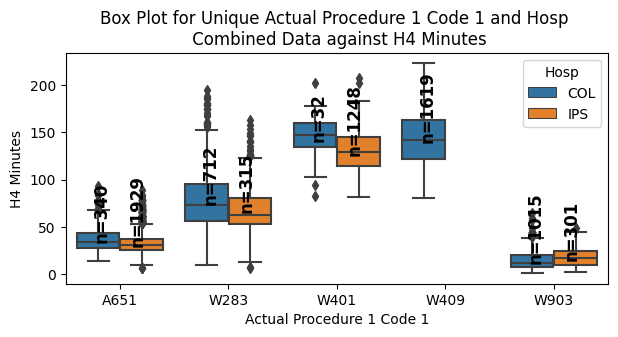

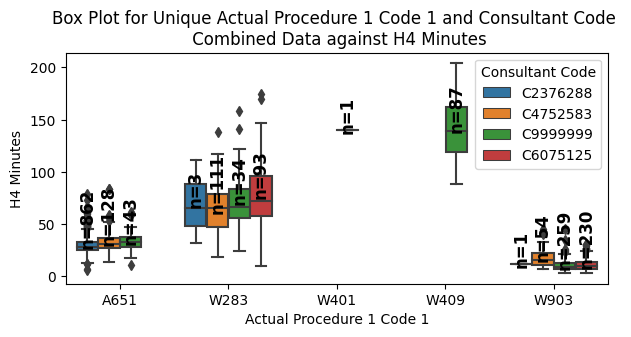

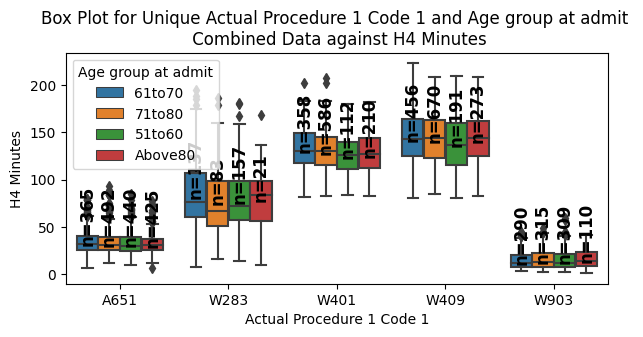

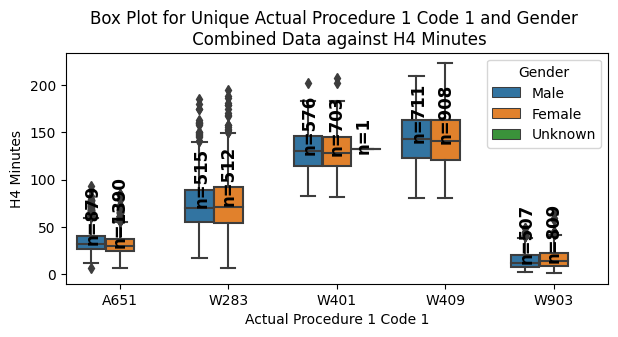

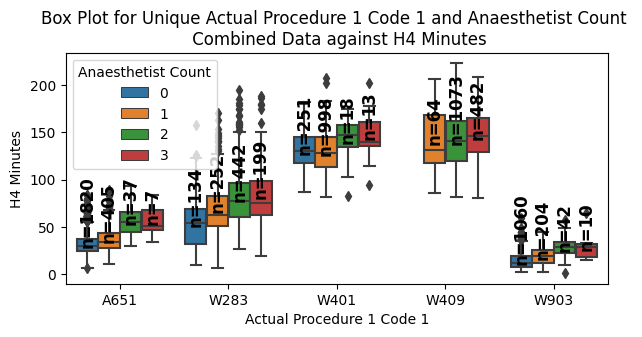

In [10]:
analysis_results = [generate_box_plot(preprocess_result[0][1], {'Actual Procedure 1 Code 1': 5, other_feature:4},
                   'H4 Minutes', (7, 3), (0.3,0.9), True) for other_feature in model_input_features_addi[0:5]]

####  Modelling and Parameters

In [10]:
import torch.optim as optim
def get_model_training_related_parameters(model_type):
    
    if model_type == 'RegressionPipeline&ElNet':
        #settting variables for pipline model step and parameters for GridSearchCV
        #el_net_pipeline= ('elasticnet', ElasticNet())
        pipeline_param = {'elasticnet__l1_ratio':[0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1], 
               'elasticnet__alpha':[ 0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.]}
        #parameters.extend([el_net_pipeline, pipeline_param])
        return pipeline_param

    elif model_type == 'NeuralNet':

        param_grid = {
        'learning_rates': [0.005, 0.01, 0.05],
        'num_epochs_list': [20, 30, 50, 80],
        #'hidden_dims': [(18), (18,18), (32), (64), (128), (32,32)  , (32,64), (64, 64), (128,64), (32,64,32), (64,64,64), (64,128,64)],
        'hidden_dims': [(18), (18,32), (32), (18,32,18), (128), (32,32) , (32,64), (64, 64), (128,64), (32,64,32), (64,64,64), (64,128,64)],
        'optimizer_classes': [optim.SGD, optim.Adam, optim.RMSprop],
        'batch_sizes': [32, 64, 128] 
        }
        return param_grid
        
    
    elif model_type == 'DecisionTreeRegressor':
        param_grid = {
        'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
        'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
        }
        return param_grid
        
        
    elif model_type == 'GradientBoostingRegressor':
        param_grid = {
        #'n_estimators': [100, 250, 400],
        #'learning_rate': [0.01, 0.1, 0.5],
        #'max_depth': [4, 5, 10]
        
        'n_estimators': [100, 200, 300],          # Limit to smaller ranges initially
        'learning_rate': [0.05, 0.1, 0.2],        # Balance between exploration and smaller step sizes
        'max_depth': [3, 5, 7],                   # Avoid very deep trees; 3-7 is reasonable for most tasks
        'min_samples_split': [2, 5, 10],          # Add regularization to control overfitting
        'min_samples_leaf': [1, 5, 10],           # Another regularization parameter
        'subsample': [0.8, 1.0] 
        }
        return param_grid
    
    elif model_type == 'SupportVectorRegression':
        '''
        param_grid = {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2],
        'gamma': ['scale', 'auto', 0.1, 1]
        }
        '''
        param_grid = {
        'kernel': ['linear','rbf', 'poly'],
        'C': [0.1, 1],
        'epsilon': [0.01,0.1],
        'gamma': [ 'auto']
        }
        return param_grid
    
    elif model_type == 'BayesianRidge':
        param_grid = {
        'max_iter': [100, 200, 300],
        'alpha_1': [1e-6, 1e-5, 1e-4],
        'alpha_2': [1e-6, 1e-5, 1e-4],
        'lambda_1': [1e-6, 1e-5, 1e-4],
        'lambda_2': [1e-6, 1e-5, 1e-4],
        }
        return param_grid

In [12]:
from predictive_model_related_functions import model_training_nd_testing_results

### Performance on Testing for all data

Prediction Test Result 
 RMSE: 32.17
MAPE: 0.53
R2: 0.7


Text(0.5, 1.0, 'Consultant Planning Vs Real Time')

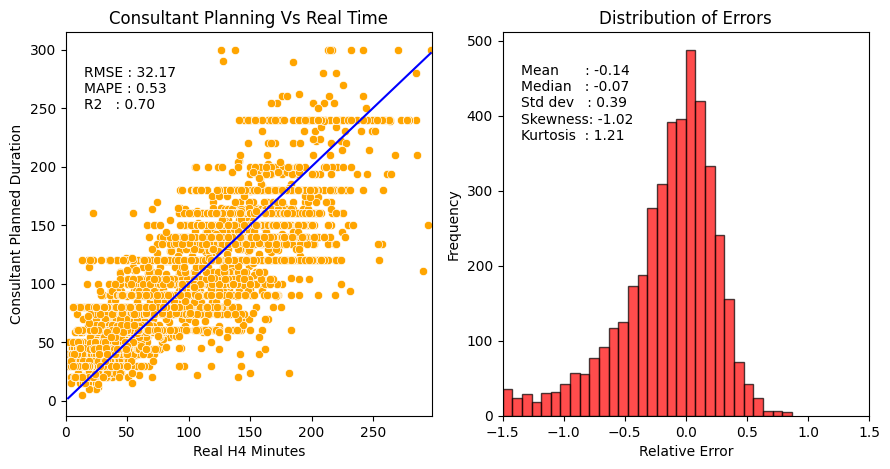

In [34]:
current_status = plot_with_performance_test(' ', test_data['H4 Minutes'],test_data['Planned Duration'], error_dist_plot = True)
#current_status[-2].set_size_inches(3.5, 3)
#current_status[-2].set_dpi(150)
current_status[-2].set_ylabel('Consultant Planned Duration')
#plot_results[-1].set_xlabel('Percentage Error')
current_status[-2].set_title('Consultant Planning Vs Real Time')
#plt.close()


Prediction Test Result 
 RMSE: 32.17
MAPE: 0.53
R2: 0.7


Text(0.5, 1.0, 'Consultant Planning')

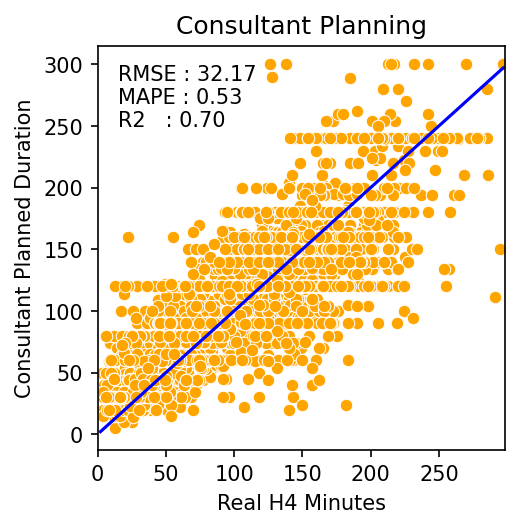

In [35]:
current_status = plot_with_performance_test(' ', test_data['H4 Minutes'],test_data['Planned Duration'], error_dist_plot = False)
current_status[-2].set_size_inches(3.5, 3.5)
current_status[-2].set_dpi(150)
current_status[-1].set_ylabel('Consultant Planned Duration')
#plot_results[-1].set_xlabel('Percentage Error')
current_status[-1].set_title('Consultant Planning')
#plt.close()

Starting to prepare for model Training: RP&EN_H4M_AHCAGADCNODaP_TaO_model
Fitting 5 folds for each of 72 candidates, totalling 360 fits
CV Best RMSE Score: -23.68
Training time: 529.49 seconds
Prediction Test Result 
 RMSE: 24.29
MAPE: 0.27
R2: 0.83


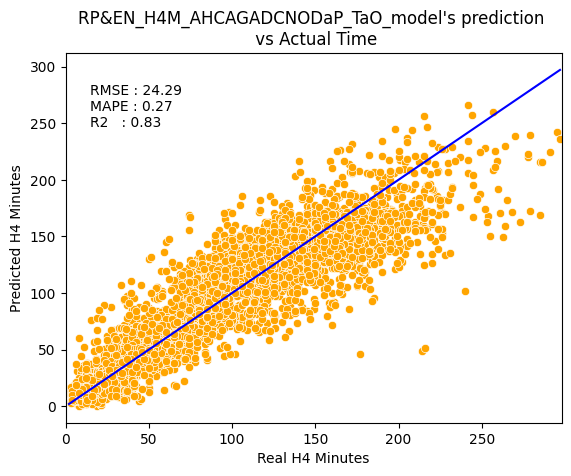

In [41]:
#model_type = 'NeuralNet'
model_type ='RegressionPipeline&ElNet'
#model_type = 'StochasticNormalDistribution'
#model_type = 'GradientBoostingRegressor'

model_retrain = False

training_related_parameters = get_model_training_related_parameters(model_type)

Trained_res, Test_res = model_training_nd_testing_results(model_type, training_related_parameters, target_data_types,model_input_features_ess+model_input_features_addi, dict_for_data_model_categorisation, IO_datasets, model_retrain, True, trained_model_dir=Trained_models_direc)

#Test_res[0][-3].set_size_inches((9,4))
#Test_res[0][-2].set_title('GBoost Prediction vs True H4 Minutes')
#Test_res[0][-1].set_title("GBoost Model's Error Distribution")
#Test_res[0][-1].set_size_inches((3,3))
#Test_res[0][-3].savefig('Output_files\GBoost Prediction all.png', dpi=150)

Prediction Test Result 
 RMSE: 24.34
MAPE: 0.24
R2: 0.83


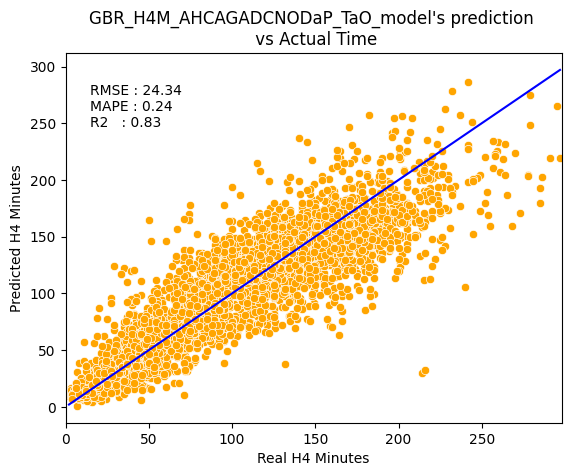

In [18]:
#model_type ='RegressionPipeline&ElNet'
#model_type = 'StochasticNormalDistribution'
model_type = 'GradientBoostingRegressor'

model_retrain = False

training_related_parameters = get_model_training_related_parameters(model_type)

Trained_res, Test_res = model_training_nd_testing_results(model_type, training_related_parameters, target_data_types,model_input_features_ess+model_input_features_addi, dict_for_data_model_categorisation, IO_datasets, model_retrain, True, trained_model_dir=Trained_models_direc)

#Test_res[0][-3].set_size_inches((9,4))
#Test_res[0][-2].set_title('GBoost Prediction vs True H4 Minutes')
#Test_res[0][-1].set_title("GBoost Model's Error Distribution")
#Test_res[0][-1].set_size_inches((3,3))
#Test_res[0][-3].savefig('Output_files\GBoost Prediction all.png', dpi=150)

##### Shapley Analysis with GBOOST model

In [16]:
import shap

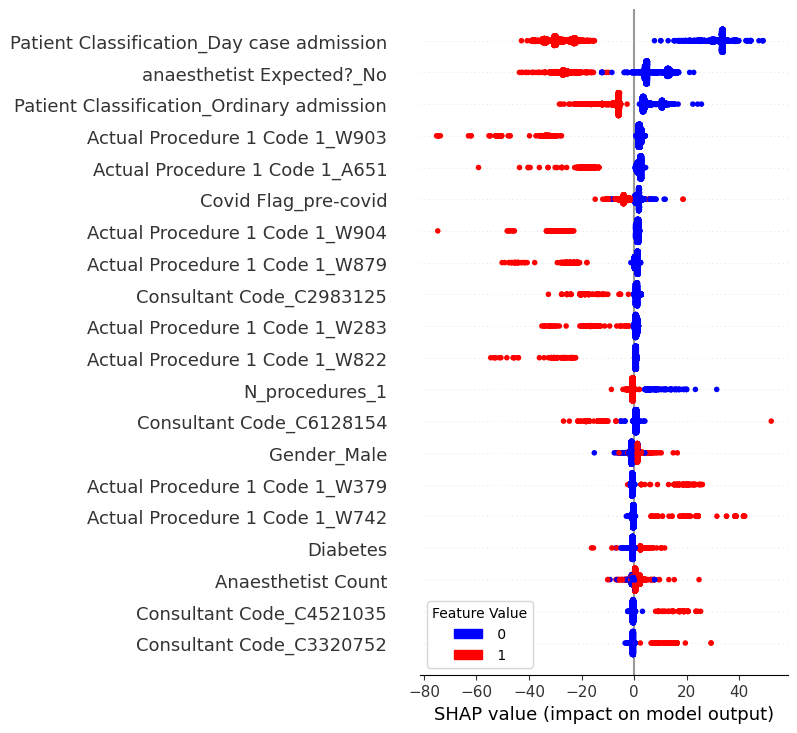

In [19]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, Normalize

explainer = shap.Explainer(Trained_res[0][1].best_estimator_)

test_data_encoded = Trained_res[0][-2].copy()
# Calculate SHAP values for a subset of the data (such as test set)
shap_values = explainer.shap_values(test_data_encoded)


# Define custom color mapping for binary features
def binary_color(val):
    if val == 1:
        return '#FF0000'  # Red for value 1
    elif val == 0:
        return '#0000FF'  # Blue for value 0
    else:
        return '#808080'  # Gray for any other value (though in your case it should only be 0 or 1)

# Update the color mapping for each feature
test_data_color = np.array([test_data_encoded.applymap(binary_color)])

# Set the figure size
plt.figure(figsize=(9, 7.5))  # Adjust as needed

# Plot the SHAP summary plot with custom color mapping
shap.summary_plot(shap_values, test_data_encoded, show=False, plot_size=None)

# Modify the color bar to only show two colors (one for 0, one for 1)
ax = plt.gca()

# Define custom colormap and normalization
cmap = ListedColormap(['#0000FF', '#FF0000'])  # Blue for low, Red for high
norm = Normalize(vmin=0, vmax=1)

# Define custom colors for "Low" and "High"
low_color = '#0000FF'  # Blue for Low (0)
high_color = '#FF0000'  # Red for High (1)

# Update the scatter plot colors to use the custom colormap and normalization
for collection in ax.collections:
    collection.set_cmap(cmap)
    collection.set_norm(norm)

fig = plt.gcf() 

for child in fig.get_children():
    if isinstance(child, plt.Axes) and child.get_label() == '<colorbar>':
        child.remove()

#cbar = plt.colorbar(ax.collections[0], orientation='vertical', ticks=[0, 1])
#cbar.ax.set_yticklabels(['0', '1'])  # Set custom tick labels

# Create custom legend
legend_handles = [
    Patch(color=low_color, label=' 0'),
    Patch(color=high_color, label=' 1')
]
plt.legend(handles=legend_handles, title='Feature Value', loc='lower left')

# Set the font size
plt.rcParams.update({'font.size': 13})

# Show the modified plot

#fig.savefig('Output_files\shap_summary_plot_6.png', bbox_inches='tight', dpi = 500)

plt.show()

Prediction Test Result 
 RMSE: 24.29
MAPE: 0.27
R2: 0.83


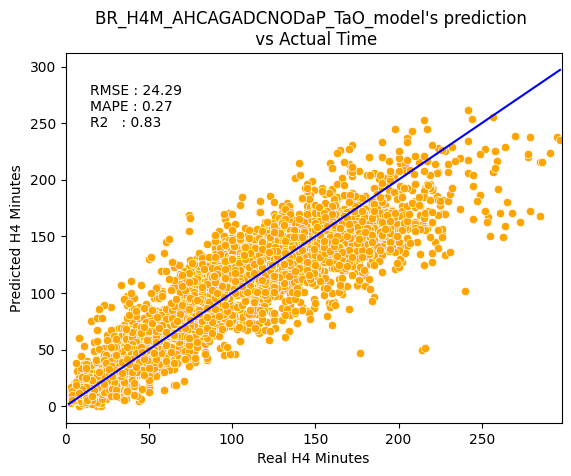

In [15]:
#model_type = 'NeuralNet'
#model_type ='RegressionPipeline&ElNet'
#model_type = 'StochasticNormalDistribution'
model_type = 'BayesianRidge'

model_retrain = False

training_related_parameters = get_model_training_related_parameters(model_type)

Trained_res, Test_res = model_training_nd_testing_results(model_type, training_related_parameters, target_data_types,model_input_features_ess+model_input_features_addi, dict_for_data_model_categorisation, IO_datasets, model_retrain, True, trained_model_dir=Trained_models_direc)

#Test_res[0][-3].set_size_inches((9,4))
#Test_res[0][-2].set_title('GBoost Prediction vs True H4 Minutes')
#Test_res[0][-1].set_title("GBoost Model's Error Distribution")
#Test_res[0][-1].set_size_inches((3,3))
#Test_res[0][-3].savefig('Output_files\GBoost Prediction all.png', dpi=150)